In [94]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
from datetime import datetime
from calendar import month_name
import matplotlib as mlb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import geopandas as gpd
import os

In [95]:
import contextily as ctx
import xyzservices.providers as xyz
from shapely.geometry import Point
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from pyproj import Transformer
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrow, Circle

def plot_stasiun_gdf(metadata):
    # Convert metadata table into a GeoDataFrame
    geometry = [Point(xy) for xy in zip(metadata['Bujur'], metadata['Lintang'])]
    stasiun_gdf = gpd.GeoDataFrame(metadata, geometry=geometry, crs="EPSG:4326")  # WGS84 coordinates
    
    # Load the ZOM shapefile
    zom_gdf = gpd.read_file('ZOM9120_DIY.shp')

    # Reproject both layers to Web Mercator (EPSG:3857) for basemap compatibility
    stasiun_gdf = stasiun_gdf.to_crs(epsg=3857)
    zom_gdf = zom_gdf.to_crs(epsg=3857)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot ZOM boundaries
    zom_gdf.plot(
        ax=ax, facecolor="none", edgecolor='black',
        linestyle='--', linewidth=1.5, label="ZOM"
    )

    # Plot rainfall stations
    stasiun_gdf.plot(ax=ax, color='red', markersize=25, label="Rainfall Station")

    # Add station name labels
    for x, y, label in zip(
        stasiun_gdf.geometry.x,
        stasiun_gdf.geometry.y,
        stasiun_gdf['Nama Stasiun']
    ):
        ax.text(x, y, label, fontsize=10, ha='left', va='bottom')

    # Add OpenTopoMap basemap (similar style to Leaflet)
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenTopoMap,
        crs=stasiun_gdf.crs,
        zoom=11,           # Higher zoom = sharper tiles
        alpha=0.7
    )

    # Turn on axis ticks
    ax.axis('on')

    # Prepare coordinate transformer (Web Mercator → WGS84 lat/lon)
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    # Format longitude tick labels
    def format_lon(x, pos):
        lon, _ = transformer.transform(x, ax.get_ylim()[0])
        return f"{lon:.2f}°E"

    # Format latitude tick labels
    def format_lat(y, pos):
        _, lat = transformer.transform(ax.get_xlim()[0], y)
        return f"{lat:.2f}°S"

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

    # Add "Indian Ocean" label in a visually positioned location
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_text = (xlim[0] + xlim[1]) / 2 - 25_000  # horizontally centered
    y_text = ylim[0] + 0.1 * (ylim[1] - ylim[0])  # 10% from bottom

    ax.text(
        x_text, y_text, "INDIAN OCEAN",
        fontsize=12, color='#27ADF5',
        fontweight='bold', alpha=0.75,
        ha='center', va='center', rotation=-20
    )

    # Add map scale bar
    scalebar = ScaleBar(
        dx=1, units="m", dimension="si-length",
        location='lower left', length_fraction=0.1,
        scale_loc='bottom', box_alpha=0.5
    )
    ax.add_artist(scalebar)

    # Add north arrow
    ax.annotate(
        '',
        xy=(0.97, 0.96), xytext=(0.97, 0.92),
        arrowprops=dict(facecolor='black', width=2, headwidth=8),
        xycoords='axes fraction'
    )

    # Add the letter 'N' below the north arrow
    ax.text(
        0.97, 0.975, 'N',
        transform=ax.transAxes,
        ha='center', va='center',
        fontsize=10, fontweight='bold'
    )

    # Add CRS information
    crs_info = "CRS: EPSG:3857 (Web Mercator)"
    ax.text(
        0.005, 0.05, crs_info,
        transform=ax.transAxes,
        fontsize=8, ha='left', va='bottom'
    )

    # Title and legend
    map_title = (
        str(stasiun_gdf['Nama Stasiun'].count())
        + " Rainfall Stations in DIY\n"
        + year_start + " to 2024-12-31"
    )
    ax.set_title(map_title, fontsize=14)

    # Create a manual legend
    legend_zom = mlines.Line2D(
        [], [], color='black', linestyle='--',
        linewidth=1.5, label='ZOM Boundary'
    )
    legend_stasiun = plt.Line2D(
        [], [], color='red', marker='o',
        linestyle='None', markersize=8,
        label='Rainfall Station'
    )

    ax.legend(
        handles=[legend_zom, legend_stasiun],
        loc="lower right", fontsize=10
    )

    plt.tight_layout()
    plt.show()


In [96]:
# Plot station with ZOM label
import contextily as ctx
import xyzservices.providers as xyz
from shapely.geometry import Point
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from pyproj import Transformer
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrow, Circle

def plot_stasiun_gdf(metadata):

    # Convert metadata table into a GeoDataFrame
    geometry = [Point(xy) for xy in zip(metadata['Bujur'], metadata['Lintang'])]
    stasiun_gdf = gpd.GeoDataFrame(metadata, geometry=geometry, crs="EPSG:4326")

    # Load ZOM shapefile
    zom_gdf = gpd.read_file('ZOM9120_DIY.shp')

    # Reproject both GeoDataFrames to Web Mercator
    stasiun_gdf = stasiun_gdf.to_crs(epsg=3857)
    zom_gdf = zom_gdf.to_crs(epsg=3857)

    # Compute centroid for each ZOM polygon and store ZOM label
    zom_gdf["centroid"] = zom_gdf.geometry.centroid
    # If your shapefile has ZOM code column, e.g. "ZOM", adjust accordingly
    zom_gdf["ZOM_label"] = zom_gdf["ZOM"] if "ZOM" in zom_gdf.columns else zom_gdf.index.astype(str)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot ZOM boundaries
    zom_gdf.plot(
        ax=ax, facecolor="none", edgecolor='black',
        linestyle='--', linewidth=1.5, label="ZOM"
    )

    # Add ZOM centroid labels
    for idx, row in zom_gdf.iterrows():
        cx, cy = row["centroid"].x, row["centroid"].y
        ax.text(
            cx, cy, row["ZOM_label"],
            fontsize=16, fontweight="bold",
            ha='center', va='center',
            color='darkblue',
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="yellow", pad=1.5)
        )

    # Plot rainfall stations
    stasiun_gdf.plot(ax=ax, color='red', markersize=25, label="Rainfall Station")

    # Add station name labels
    for x, y, label in zip(
        stasiun_gdf.geometry.x,
        stasiun_gdf.geometry.y,
        stasiun_gdf['Nama Stasiun']
    ):
        ax.text(x, y, label, fontsize=10, ha='left', va='bottom')

    # Add OpenTopoMap basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenTopoMap,
        crs=stasiun_gdf.crs,
        zoom=11,
        alpha=0.7
    )

    # Turn on axis ticks
    ax.axis('on')

    # Coordinate transformer for tick formatting
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    def format_lon(x, pos):
        lon, _ = transformer.transform(x, ax.get_ylim()[0])
        return f"{lon:.2f}°E"

    def format_lat(y, pos):
        _, lat = transformer.transform(ax.get_xlim()[0], y)
        return f"{lat:.2f}°S"

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

    # Indian Ocean text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_text = (xlim[0] + xlim[1]) / 2 - 25_000
    y_text = ylim[0] + 0.1 * (ylim[1] - ylim[0])

    ax.text(
        x_text, y_text, "INDIAN OCEAN",
        fontsize=12, color='#27ADF5',
        fontweight='bold', alpha=0.75,
        ha='center', va='center', rotation=-20
    )

    # Scale bar
    scalebar = ScaleBar(
        dx=1, units="m", dimension="si-length",
        location='lower left', length_fraction=0.1,
        scale_loc='bottom', box_alpha=0.5
    )
    ax.add_artist(scalebar)

    # North arrow
    ax.annotate(
        '',
        xy=(0.97, 0.96), xytext=(0.97, 0.92),
        arrowprops=dict(facecolor='black', width=2, headwidth=8),
        xycoords='axes fraction'
    )

    ax.text(
        0.97, 0.975, 'N',
        transform=ax.transAxes,
        ha='center', va='center',
        fontsize=10, fontweight='bold'
    )

    # CRS info
    ax.text(
        0.005, 0.05, "CRS: EPSG:3857 (Web Mercator)",
        transform=ax.transAxes,
        fontsize=8, ha='left', va='bottom'
    )

    # Title
    map_title = (
        str(stasiun_gdf['Nama Stasiun'].count())
        + " Rainfall Stations in DIY\n"
        + year_start + " to 2024-12-31"
    )
    ax.set_title(map_title, fontsize=14)

    # Manual legend
    legend_zom = mlines.Line2D(
        [], [], color='black', linestyle='--', linewidth=1.5, label='ZOM Boundary'
    )
    legend_stasiun = plt.Line2D(
        [], [], color='red', marker='o',
        linestyle='None', markersize=8,
        label='Rainfall Station'
    )

    ax.legend(
        handles=[legend_zom, legend_stasiun],
        loc="lower right", fontsize=10
    )

    plt.tight_layout()
    plt.show()


In [97]:
# Load station metadata from CSV
# The file uses semicolon separators and the actual column header starts on the second row (header=1)
metadata = pd.read_csv('pos_hujan_metadata.csv', sep=";", header=1)

# Set "Pos Hujan ID" as the index for easier referencing and lookup
metadata = metadata.set_index(['Pos Hujan ID'])

# Display the metadata table
metadata

Nama Stasiun      Balai       Provinsi  \
Pos Hujan ID                                                                 
34010101a                              BPP Temon  Region II  DI Yogyakarta   
34010201a                                   Beji  Region II  DI Yogyakarta   
34010202a                            BPP Kulwaru  Region II  DI Yogyakarta   
34010301a                           BPP Panjatan  Region II  DI Yogyakarta   
34010401a                            PSDA Brosot  Region II  DI Yogyakarta   
...                                          ...        ...            ...   
34711303a                  Polbangtan Yogyakarta  Region II  DI Yogyakarta   
34040105a                        STPN Yogyakarta  Region II  DI Yogyakarta   
34710102a                  Kebun Benih Tegalrejo  Region II  DI Yogyakarta   
34010104a         Stasiun Meteorologi Yogyakarta  Region II  DI Yogyakarta   
34041107a     Laboratorium Tanah BPTP Yogyakarta  Region II  DI Yogyakarta   

                     Kabupaten  Lintang      Bujur  Elevasi  
Pos Hujan ID                                                 
34010101a     Kab. Kulon Progo -7.89000  110.08000      0.0  
34010201a     Kab. Kulon Progo -7.87300  110.16200      0.0  
34010202a     Kab. Kulon Progo -7.89000  110.11700      0.0  
34010301a     Kab. Kulon Progo -7.92308  110.15800      0.0  
34010401a     Kab. Kulon Progo -7.95000  110.22400      0.0  
...                        ...      ...        ...      ...  
34711303a      Kota Yogyakarta -7.80250  110.38139    101.0  
34040105a          Kab. Sleman -7.78278  110.34444    114.0  
34710102a      Kota Yogyakarta -7.77500  110.36200    127.0  
34010104a     Kab. Kulon Progo -7.90343  110.06707      8.0  
34041107a          Kab. Sleman -7.75006  110.41980    172.0  

[129 rows x 7 columns]

In [98]:
# Load raw rainfall data
# The CSV uses comma separators and the first row contains column names
raw_data = pd.read_csv('export-pos-hujan-1981-01-01-2024-12-31.csv', sep=",", header=0)

# Convert the timestamp column to a timezone-naive datetime format
raw_data['DATA TIMESTAMP'] = (
    pd.to_datetime(raw_data['DATA TIMESTAMP'])
    .dt.tz_localize(None)
)

# Set a multi-index: timestamp + station ID
raw_data = raw_data.set_index(['DATA TIMESTAMP', 'POS HUJAN ID'])

# Display the processed dataset
raw_data

/var/folders/9g/y4lb5z2j2jg8m_dmhp5c6bjh0000gn/T/ipykernel_81619/3211626375.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(raw_data['DATA TIMESTAMP'])


RAINFALL DAY MM
DATA TIMESTAMP POS HUJAN ID                 
1994-01-01     34010101a              9999.0
1994-01-02     34010101a              9999.0
1994-01-03     34010101a              9999.0
1994-01-04     34010101a              9999.0
1994-01-05     34010101a              9999.0
...                                      ...
2024-12-27     34711303a                 6.3
2024-12-28     34711303a                 0.0
2024-12-29     34711303a                14.5
2024-12-30     34711303a                 8.0
2024-12-31     34711303a                 1.2

[1289533 rows x 1 columns]

In [99]:
# Convert the rainfall series into a table (pivot) format
# Rows = dates, Columns = station IDs
data_daily = raw_data['RAINFALL DAY MM'].unstack(level=-1)

# Replace the value 8888 (TTU) with 0 mm
data_daily[data_daily == 8888] = 0

# Replace the value 9999 (missing data code) with NaN
data_daily[data_daily == 9999] = np.nan

# Remove stations whose entire column is NaN (no valid data)
data_daily = data_daily.dropna(axis=1, how='all')

# Display the cleaned daily rainfall table
data_daily

POS HUJAN ID    34010101a  34010104a  34010201a  34010202a  34010301a  \
DATA TIMESTAMP                                                          
1981-01-01            NaN        NaN        NaN        NaN        0.0   
1981-01-02            NaN        NaN        NaN        NaN       25.0   
1981-01-03            NaN        NaN        NaN        NaN       30.0   
1981-01-04            NaN        NaN        NaN        NaN        9.0   
1981-01-05            NaN        NaN        NaN        NaN       21.0   
...                   ...        ...        ...        ...        ...   
2024-12-27           35.0       38.1       17.6       29.0       31.5   
2024-12-28            0.0        0.0        0.0        0.0        0.0   
2024-12-29           11.0        4.4        9.0        6.5        6.0   
2024-12-30           17.0       21.3       14.7       20.5       19.5   
2024-12-31            3.0        3.5        5.6        7.5        6.0   

POS HUJAN ID    34010401a  34010402a  34010501a  34010601a  34010602a  ...  \
DATA TIMESTAMP                                                         ...   
1981-01-01            0.0        NaN        NaN        7.0        NaN  ...   
1981-01-02           15.0        NaN        NaN        0.0        NaN  ...   
1981-01-03           25.0        NaN        NaN        1.0        NaN  ...   
1981-01-04            0.0        NaN        NaN       19.0        NaN  ...   
1981-01-05           23.0        NaN        NaN       10.0        NaN  ...   
...                   ...        ...        ...        ...        ...  ...   
2024-12-27           23.0       21.5       23.0       13.0      115.5  ...   
2024-12-28            1.0        0.0        5.0        0.0        0.0  ...   
2024-12-29            3.0        6.0        4.0       13.0        8.1  ...   
2024-12-30           10.0       14.0       15.0       12.0       29.0  ...   
2024-12-31            0.0        2.5        7.0        3.0        0.0  ...   

POS HUJAN ID    34041505a  34041601a  34041603a  34041701a  34041702a  \
DATA TIMESTAMP                                                          
1981-01-01            NaN        NaN        NaN        NaN        NaN   
1981-01-02            NaN        NaN        NaN        NaN        NaN   
1981-01-03            NaN        NaN        NaN        NaN        NaN   
1981-01-04            NaN        NaN        NaN        NaN        NaN   
1981-01-05            NaN        NaN        NaN        NaN        NaN   
...                   ...        ...        ...        ...        ...   
2024-12-27           12.5       10.5       22.0       10.0        4.5   
2024-12-28            0.0        0.0        0.0        0.0        0.0   
2024-12-29            7.0       10.5        5.0       11.0        8.0   
2024-12-30            5.0        5.0        3.0        6.0        0.5   
2024-12-31           17.0       45.5       14.0       33.5       18.5   

POS HUJAN ID    34041704a  34710102a  34710401a  34711302a  34711303a  
DATA TIMESTAMP                                                         
1981-01-01            NaN        NaN        NaN        NaN        NaN  
1981-01-02            NaN        NaN        NaN        NaN        NaN  
1981-01-03            NaN        NaN        NaN        NaN        NaN  
1981-01-04            NaN        NaN        NaN        NaN        NaN  
1981-01-05            NaN        NaN        NaN        NaN        NaN  
...                   ...        ...        ...        ...        ...  
2024-12-27            5.5       15.5       10.0       12.0        6.3  
2024-12-28            0.0        0.0        0.0        0.0        0.0  
2024-12-29           18.0       22.0       17.0        5.0       14.5  
2024-12-30            2.0        8.2        8.0       19.0        8.0  
2024-12-31           21.0        1.0        0.0        1.5        1.2  

[16071 rows x 126 columns]

In [127]:
# Remove station with distance between nearest neighbor < 500 m
cols_to_remove = ["34040202a", "34021604a"]

# Hapus kolom jika ada dalam dataframe
data_daily = data_daily.drop(columns=cols_to_remove, errors="ignore")

print("Done: kolom berikut telah dihapus dari data_daily:")
print(cols_to_remove)


Done: kolom berikut telah dihapus dari data_daily:
['34040202a', '34021604a']


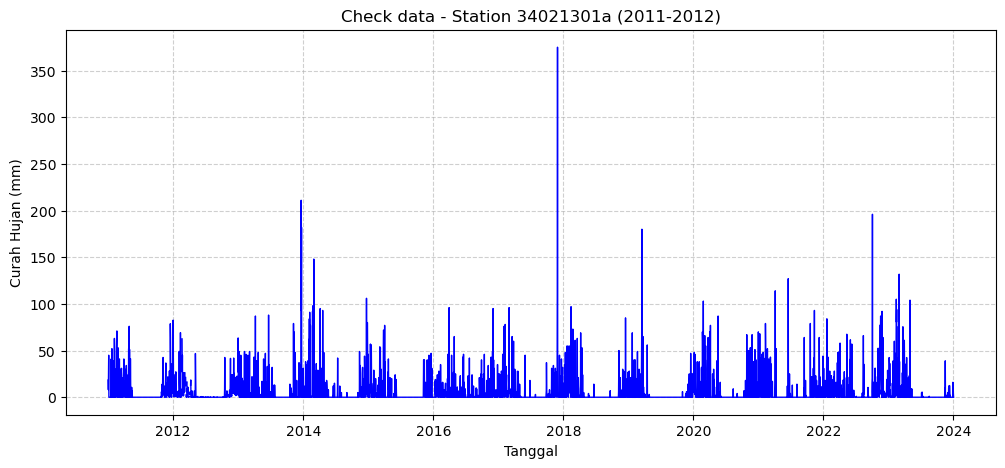

In [163]:
# Filter data tahun 2015-2016 untuk stasiun
station_id = "34021301a"
data_plot = data_daily.loc["2011-01-01":"2024-01-02", station_id]

# Plot data
plt.figure(figsize=(12,5))
plt.plot(data_plot.index, data_plot.values, color="blue", linewidth=1)
plt.title(f"Check data - Station {station_id} (2011-2012)")
plt.xlabel("Tanggal")
plt.ylabel("Curah Hujan (mm)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



In [157]:
# Match available rainfall stations with the metadata
# Extract the set of station IDs present in the daily rainfall table
pos_hujan_tersedia = set(data_daily.columns) - {"DATA TIMESTAMP"}

# Filter the metadata to keep only stations that exist in the rainfall dataset
metadata_cleaned = metadata[metadata.index.isin(pos_hujan_tersedia)]

# Save the cleaned metadata and daily rainfall data to Excel files
metadata_cleaned.to_excel(
    f"data/metadata_raw_{len(metadata_cleaned.index)}pos.xlsx"
)
data_daily.to_excel(
    f"data/dailyprecip_raw_{len(data_daily.columns)}pos.xlsx"
)

# Display cleaned metadata
metadata_cleaned

Nama Stasiun      Balai       Provinsi  \
Pos Hujan ID                                                                 
34010101a                              BPP Temon  Region II  DI Yogyakarta   
34010201a                                   Beji  Region II  DI Yogyakarta   
34010202a                            BPP Kulwaru  Region II  DI Yogyakarta   
34010301a                           BPP Panjatan  Region II  DI Yogyakarta   
34010401a                            PSDA Brosot  Region II  DI Yogyakarta   
...                                          ...        ...            ...   
34711303a                  Polbangtan Yogyakarta  Region II  DI Yogyakarta   
34040105a                        STPN Yogyakarta  Region II  DI Yogyakarta   
34710102a                  Kebun Benih Tegalrejo  Region II  DI Yogyakarta   
34010104a         Stasiun Meteorologi Yogyakarta  Region II  DI Yogyakarta   
34041107a     Laboratorium Tanah BPTP Yogyakarta  Region II  DI Yogyakarta   

                     Kabupaten  Lintang      Bujur  Elevasi  
Pos Hujan ID                                                 
34010101a     Kab. Kulon Progo -7.89000  110.08000      0.0  
34010201a     Kab. Kulon Progo -7.87300  110.16200      0.0  
34010202a     Kab. Kulon Progo -7.89000  110.11700      0.0  
34010301a     Kab. Kulon Progo -7.92308  110.15800      0.0  
34010401a     Kab. Kulon Progo -7.95000  110.22400      0.0  
...                        ...      ...        ...      ...  
34711303a      Kota Yogyakarta -7.80250  110.38139    101.0  
34040105a          Kab. Sleman -7.78278  110.34444    114.0  
34710102a      Kota Yogyakarta -7.77500  110.36200    127.0  
34010104a     Kab. Kulon Progo -7.90343  110.06707      8.0  
34041107a          Kab. Sleman -7.75006  110.41980    172.0  

[124 rows x 7 columns]

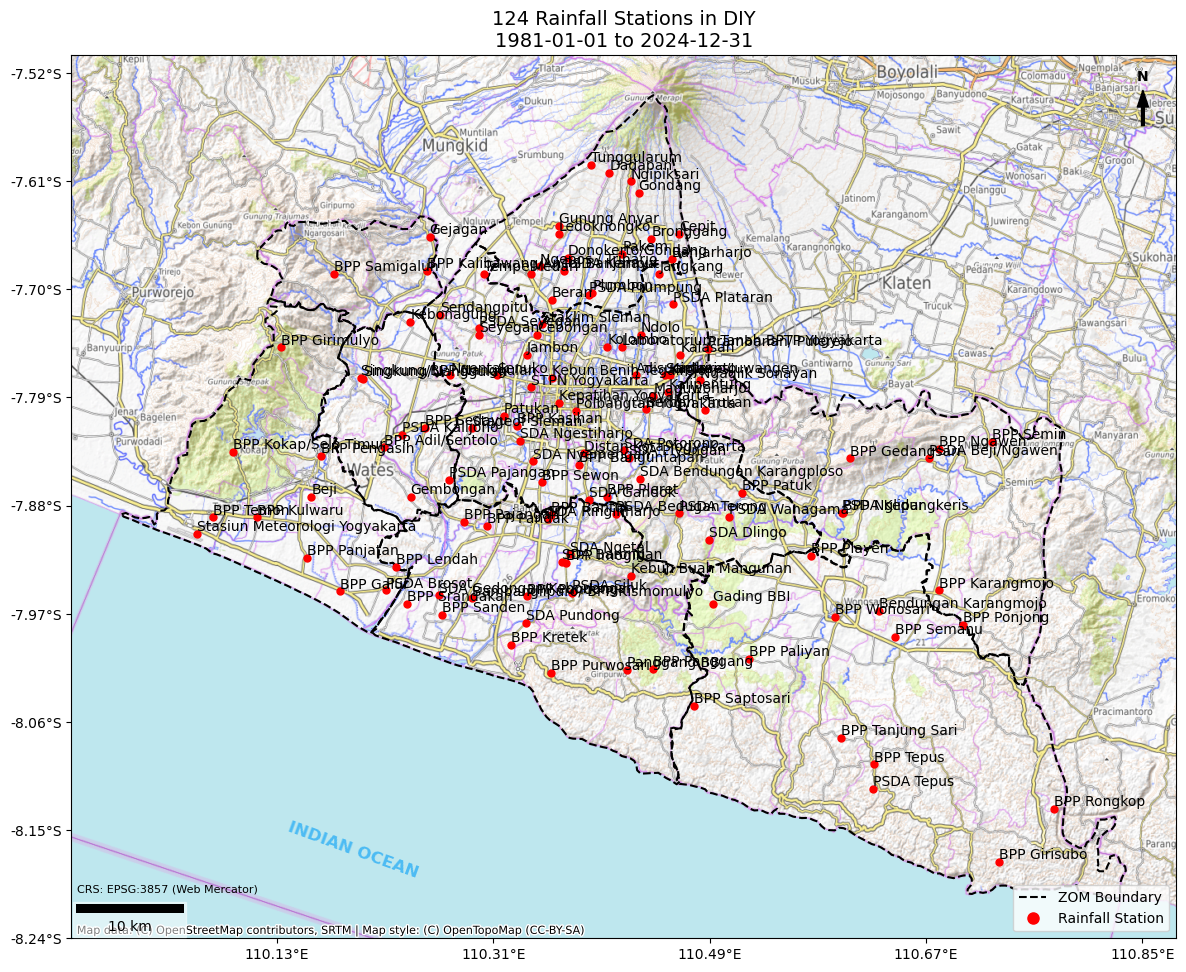

In [158]:
# Define the starting year used for the map title
year_start = '1981-01-01'

# Plot the station locations using the cleaned metadata
plot_stasiun_gdf(metadata_cleaned)

In [100]:
# Read data
metadata_cleaned = pd.read_excel("data/metadata_raw_124pos.xlsx", index_col=0)
data_daily = pd.read_excel('data/dailyprecip_raw_124pos.xlsx', index_col=0, parse_dates=True)
# Filter daily rainfall data for a specific 15-year period
year_start = '2010-01-01'
year_end   = '2024-12-31'

# Select rows (dates) within the specified range
data_filtered = data_daily.loc[year_start:year_end]

# Display the filtered dataset
data_filtered

34010101a  34010104a  34010201a  34010202a  34010301a  \
DATA TIMESTAMP                                                          
2010-01-01            0.0        NaN        0.0        0.0        0.0   
2010-01-02            0.0        NaN        0.0        0.0        0.0   
2010-01-03            0.0        NaN        0.0        0.0        0.0   
2010-01-04           11.0        NaN       13.0        0.0        0.0   
2010-01-05            8.0        NaN        0.0       12.0       11.0   
...                   ...        ...        ...        ...        ...   
2024-12-27           35.0       38.1       17.6       29.0       31.5   
2024-12-28            0.0        0.0        0.0        0.0        0.0   
2024-12-29           11.0        4.4        9.0        6.5        6.0   
2024-12-30           17.0       21.3       14.7       20.5       19.5   
2024-12-31            3.0        3.5        5.6        7.5        6.0   

                34010401a  34010402a  34010501a  34010601a  34010602a  ...  \
DATA TIMESTAMP                                                         ...   
2010-01-01            0.0        0.0        0.0        0.0        NaN  ...   
2010-01-02            0.0        0.0        0.0        0.0        NaN  ...   
2010-01-03            0.0        0.0        0.0        0.0        NaN  ...   
2010-01-04            0.0        0.0        0.0        0.0        NaN  ...   
2010-01-05           30.0       30.0       30.0        0.0        NaN  ...   
...                   ...        ...        ...        ...        ...  ...   
2024-12-27           23.0       21.5       23.0       13.0      115.5  ...   
2024-12-28            1.0        0.0        5.0        0.0        0.0  ...   
2024-12-29            3.0        6.0        4.0       13.0        8.1  ...   
2024-12-30           10.0       14.0       15.0       12.0       29.0  ...   
2024-12-31            0.0        2.5        7.0        3.0        0.0  ...   

                34041505a  34041601a  34041603a  34041701a  34041702a  \
DATA TIMESTAMP                                                          
2010-01-01            NaN       25.0        NaN       22.0        NaN   
2010-01-02            NaN        2.0        NaN        2.0        NaN   
2010-01-03            NaN        0.0        NaN        1.0        NaN   
2010-01-04            NaN        0.0        NaN        0.0        NaN   
2010-01-05            NaN        0.0        NaN        0.0        NaN   
...                   ...        ...        ...        ...        ...   
2024-12-27           12.5       10.5       22.0       10.0        4.5   
2024-12-28            0.0        0.0        0.0        0.0        0.0   
2024-12-29            7.0       10.5        5.0       11.0        8.0   
2024-12-30            5.0        5.0        3.0        6.0        0.5   
2024-12-31           17.0       45.5       14.0       33.5       18.5   

                34041704a  34710102a  34710401a  34711302a  34711303a  
DATA TIMESTAMP                                                         
2010-01-01            NaN        NaN        NaN        NaN        NaN  
2010-01-02            NaN        NaN        NaN        NaN        NaN  
2010-01-03            NaN        NaN        NaN        NaN        NaN  
2010-01-04            NaN        NaN        NaN        NaN        NaN  
2010-01-05            NaN        NaN        NaN        NaN        NaN  
...                   ...        ...        ...        ...        ...  
2024-12-27            5.5       15.5       10.0       12.0        6.3  
2024-12-28            0.0        0.0        0.0        0.0        0.0  
2024-12-29           18.0       22.0       17.0        5.0       14.5  
2024-12-30            2.0        8.2        8.0       19.0        8.0  
2024-12-31           21.0        1.0        0.0        1.5        1.2  

[5479 rows x 124 columns]

In [ ]:
import pandas as pd
import numpy as np

# List periods (start_year, end_year)
periods = [
    (1981, 2024),
    (2000, 2024),
    (2005, 2024),
    (2010, 2024),
    (2014, 2024),
    (2015, 2024),
    (2018, 2024),
]

results = []

for start, end in periods:
    # Subset data
    subset = data_daily.loc[f"{start}-01-01":f"{end}-12-31"]
    
    # Sum of days
    total_days = subset.shape[0]
    
    # Missing data proportion
    missing_ratio = subset.isna().sum() / total_days
    
    # Selection with criteria ≤ 10%
    valid_stations = missing_ratio[missing_ratio <= 0.10]
    
    # Save result
    results.append({
        "Periode": f"{start}–{end}",
        "Durasi (tahun)": end - start + 1,
        "Jumlah Pos Hujan Memenuhi Kriteria": valid_stations.count()
    })

period = pd.DataFrame(results)
period


Periode  Durasi (tahun)  Jumlah Pos Hujan Memenuhi Kriteria
0  1981–2024              44                                  44
1  2000–2024              25                                  62
2  2005–2024              20                                  74
3  2010–2024              15                                  82
4  2014–2024              11                                  90
5  2015–2024              10                                 102
6  2018–2024               7                                 115

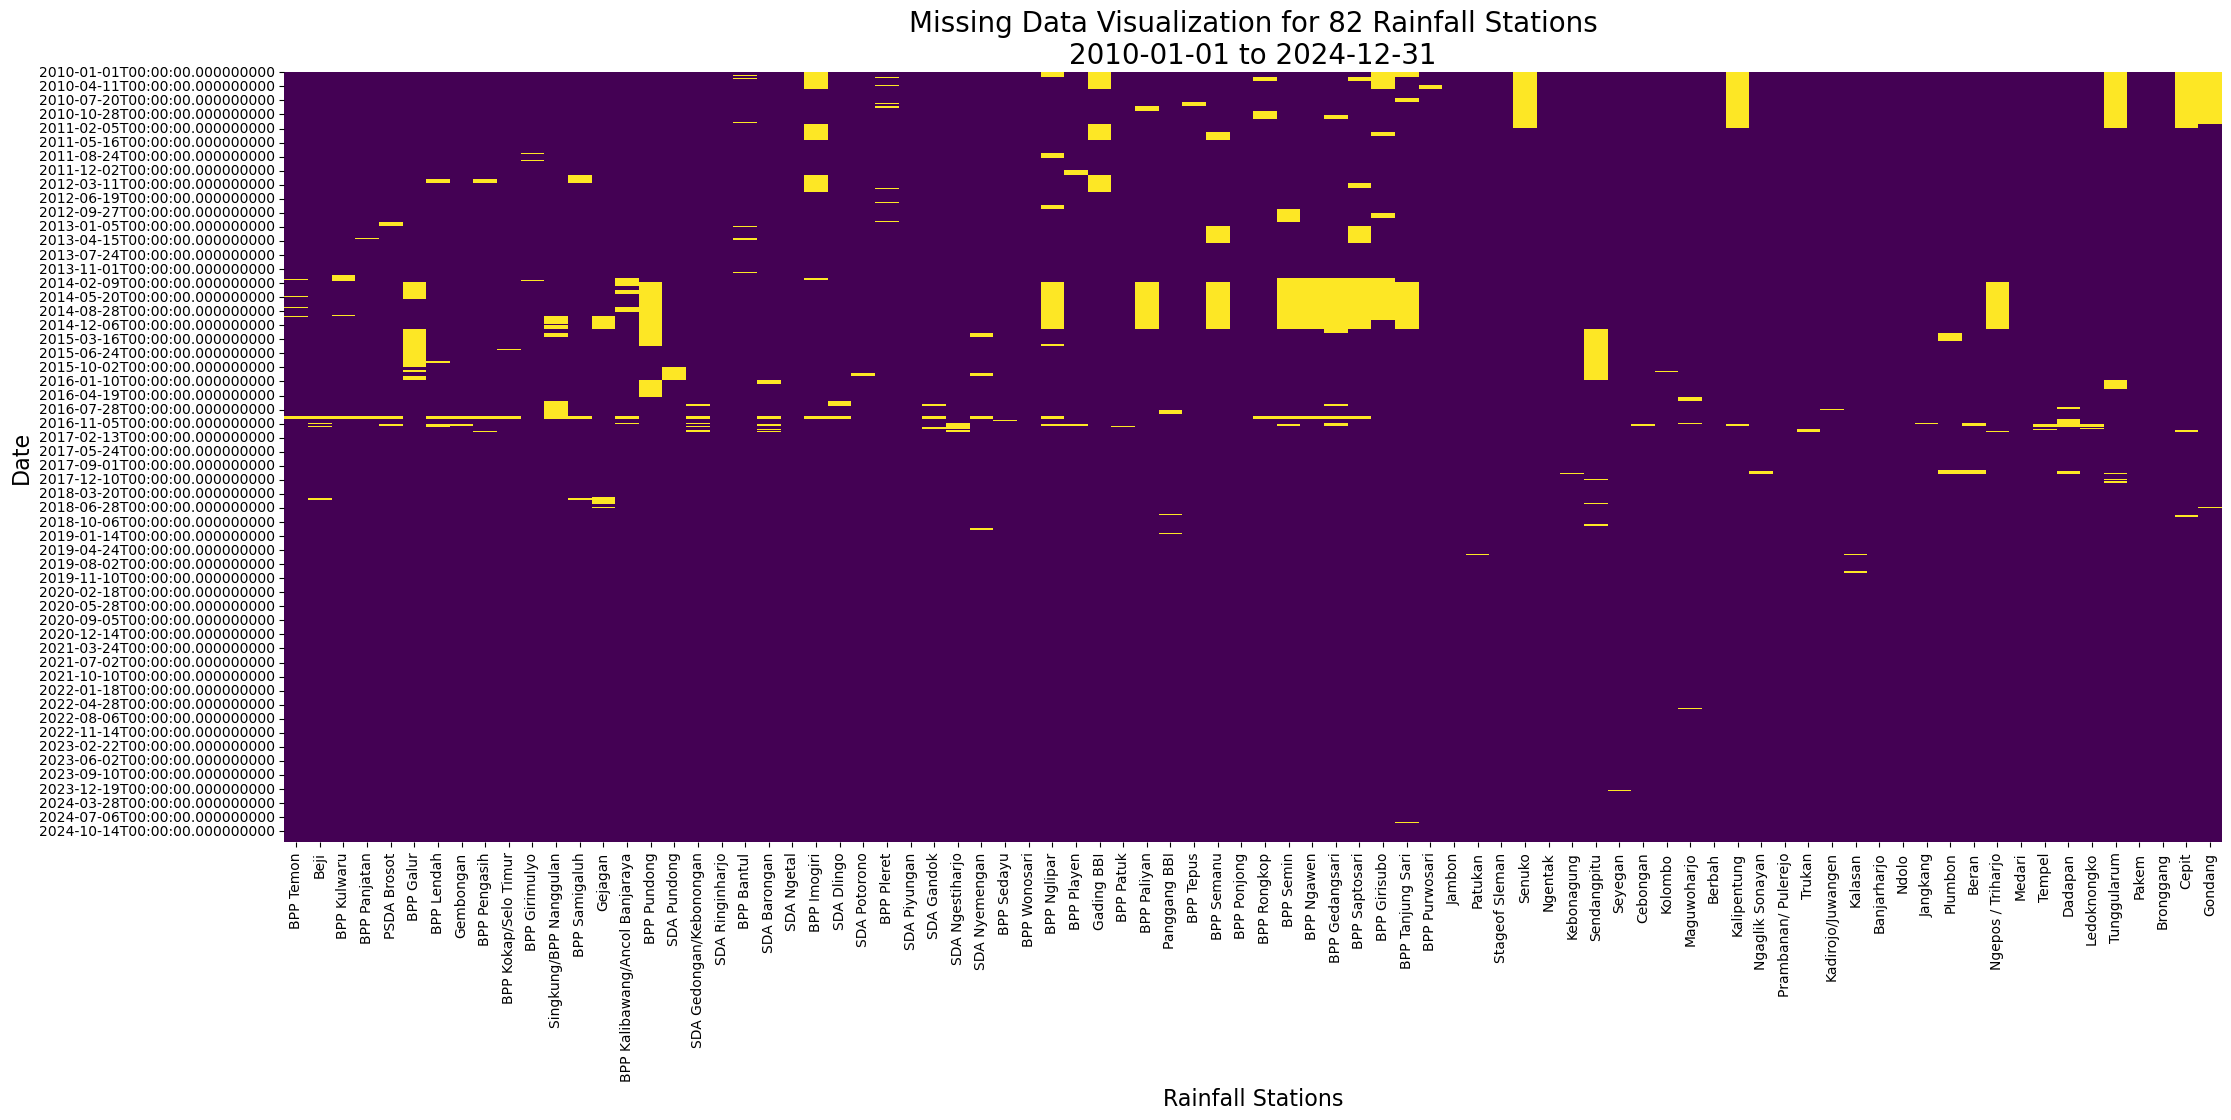

/var/folders/9g/y4lb5z2j2jg8m_dmhp5c6bjh0000gn/T/ipykernel_81619/45813962.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


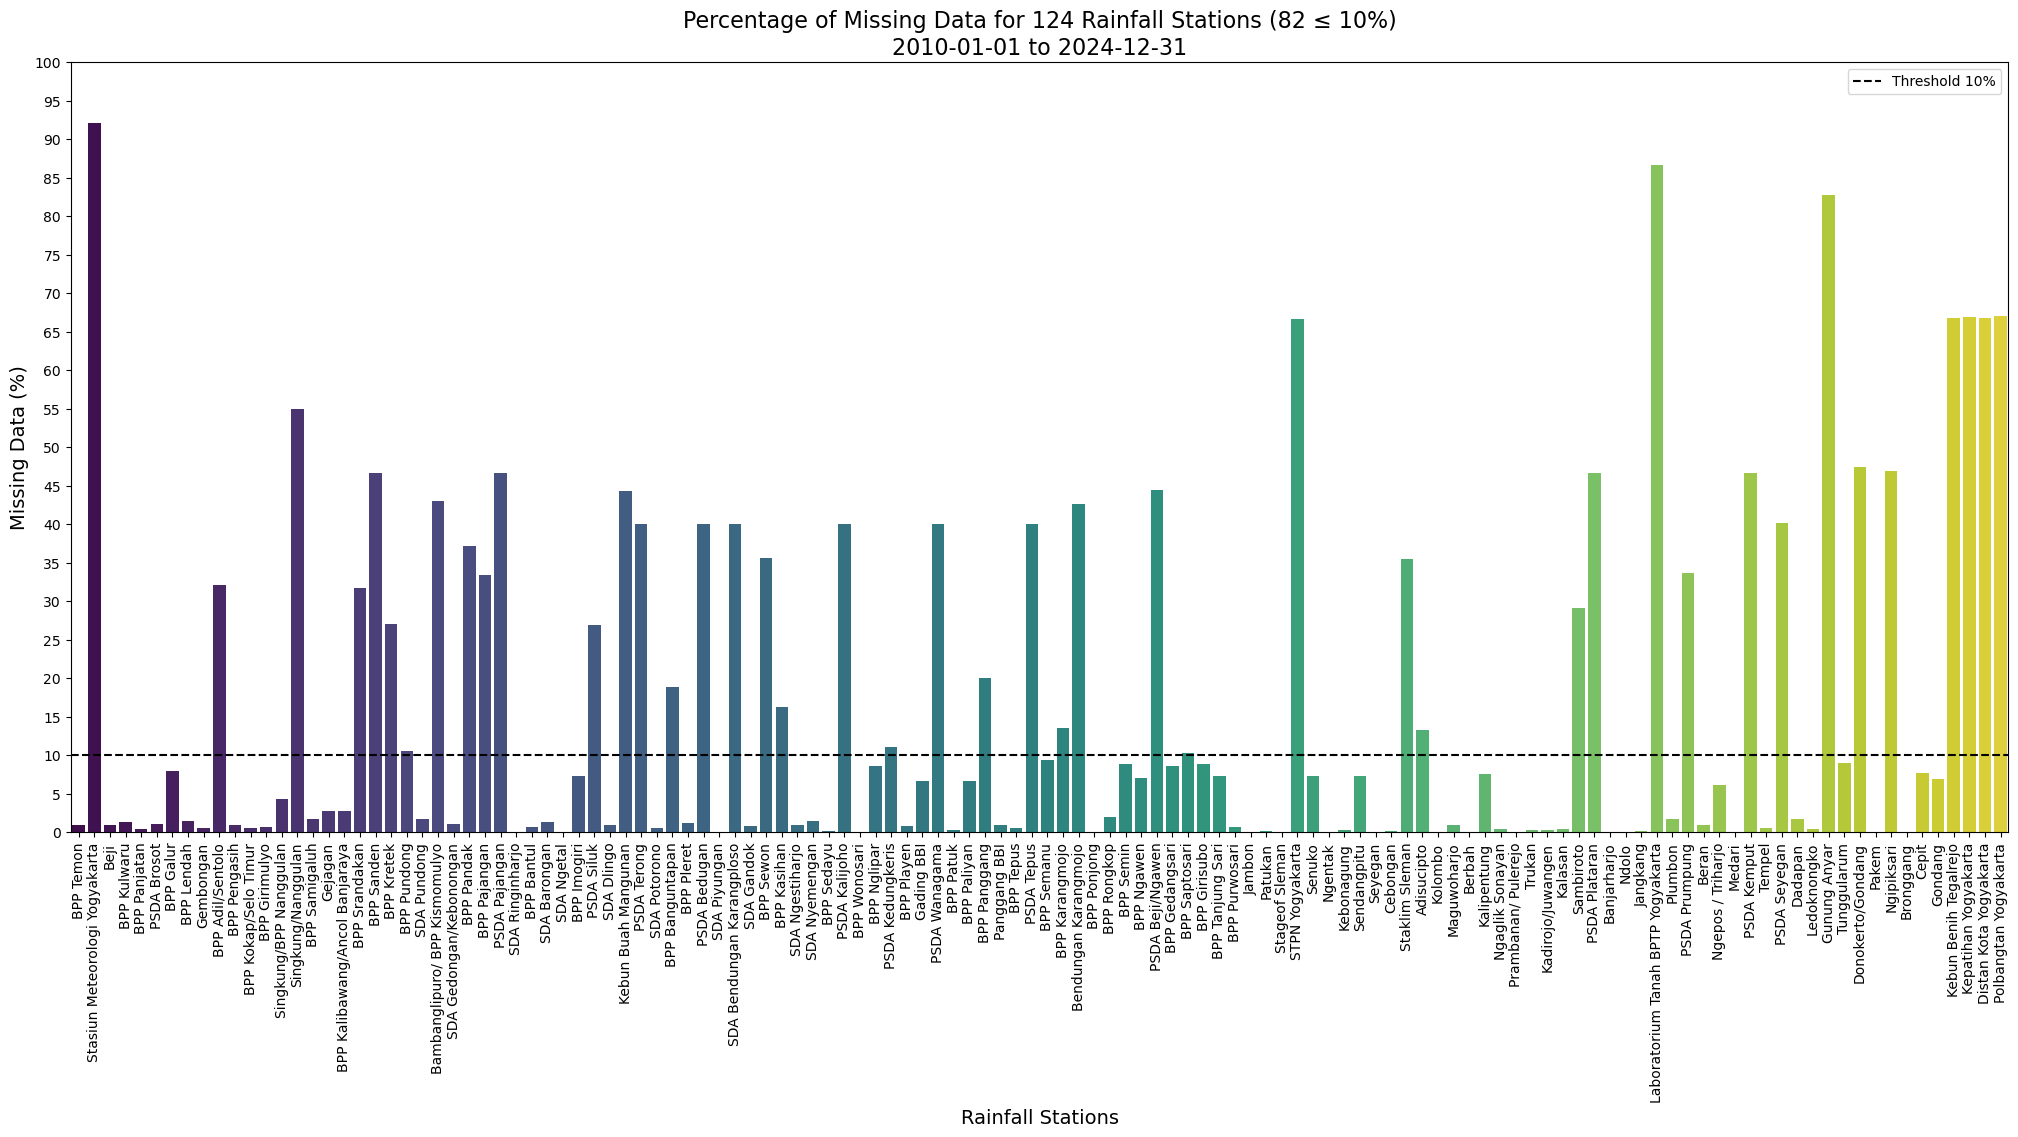

In [16]:
# Calculate the total number of days in the selected period 
# (based on the full index range, not each station's record start)
total_data_length = (data_filtered.index[-1] - data_filtered.index[0]).days + 1

# Count available (non-NaN) data for each rainfall station
available_data_counts = data_filtered.notna().sum()

# Compute the percentage of missing data for each station
missing_percentage = (1 - (available_data_counts / total_data_length)) * 100

# Determine which stations to keep or remove based on the missing data threshold
threshold = 10  # Maximum allowed missing data percentage
pos_untuk_dihapus = missing_percentage[missing_percentage > threshold].index
pos_untuk_diisi   = missing_percentage[missing_percentage <= threshold].index

# Remove stations that exceed the missing data threshold
data_filtered_new = data_filtered.drop(columns=pos_untuk_dihapus)

# Visualize missing data as a heatmap for stations meeting the threshold
plt.figure(figsize=(25, 10))
ax = sns.heatmap(
    data_filtered_new.isnull(),
    cbar=False,
    cmap="viridis"
)

plt.title(
    "Missing Data Visualization for "
    + str(len(data_filtered_new.columns)) + " Rainfall Stations\n"
    + year_start + " to 2024-12-31",
    fontsize=20
)

# Update x-axis labels with station names
ax.set_xticks(
    np.arange(len(metadata_cleaned.loc[data_filtered_new.columns]['Nama Stasiun'])) + 0.5
)  # +0.5 centers the label
ax.set_xticklabels(
    metadata_cleaned.loc[data_filtered_new.columns]['Nama Stasiun'],
    rotation=90
)

plt.xlabel("Rainfall Stations", fontsize=16)
plt.ylabel("Date", fontsize=16)
plt.show()

# Visualize the percentage of missing data as a bar plot
plt.figure(figsize=(25, 10))
sns.barplot(
    x=metadata_cleaned.loc[missing_percentage.index]['Nama Stasiun'],
    y=missing_percentage.values,
    palette="viridis"
)

plt.xticks(rotation=90)
plt.ylabel("Missing Data (%)", fontsize=14)
plt.xlabel("Rainfall Stations", fontsize=14)

plt.title(
    "Percentage of Missing Data for "
    + str(len(data_filtered.columns)) + " Rainfall Stations "
    + "(" + str(len(data_filtered_new.columns)) + " ≤ " + str(threshold) + "%)\n"
    + year_start + " to 2024-12-31",
    fontsize=16
)

plt.ylim(0, 100)                       # Show 0–100% scale
plt.yticks(np.arange(0, 105, 5))       # Set ticks every 5%
plt.axhline(
    threshold,
    color="black",
    linestyle="--",
    label=f"Threshold {threshold}%"
)
plt.legend()
plt.show()

In [17]:
# tambah BPP Pleret
import pandas as pd

station_id = "34021301a"

# Pastikan kedua index bertipe datetime
data_daily.index = pd.to_datetime(data_daily.index)
data_filtered_new.index = pd.to_datetime(data_filtered_new.index)

# Copy nilai dari dataharian → data_daily, berdasarkan tanggal yang cocok
data_filtered_new[station_id] = data_daily[station_id].reindex(data_filtered_new.index)

print("Data untuk pos hujan", station_id, "sudah berhasil dicopy.")


Data untuk pos hujan 34021301a sudah berhasil dicopy.


In [ ]:
# Match available rainfall stations with the metadata
# Extract station IDs present in the cleaned daily data table
pos_hujan_tersedia = set(data_filtered_new.columns) - {"DATA TIMESTAMP"}

# Filter metadata to keep only stations that exist in the rainfall dataset
metadata_filtered = metadata_cleaned[
    metadata_cleaned.index.isin(pos_hujan_tersedia)
]

metadata_filtered

# Save the cleaned metadata and daily rainfall data to Excel files
metadata_filtered.to_excel(
    f"data/metadata_raw_{len(metadata_filtered.index)}pos.xlsx"
)
data_filtered_new.to_excel(
    f"data/dailyprecip_raw_{len(data_filtered_new.columns)}pos.xlsx"
)


# Plot station locations based on the filtered metadata
plot_stasiun_gdf(metadata_filtered)

In [28]:
# Homogeneity testing using pyhomogeneity
import pyhomogeneity as hg
from scipy.stats import norm

In [44]:
# Aggregate daily rainfall into yearly totals
data_yearly = data_filtered_new.resample('1Y').sum()

# Display the first few rows of the yearly dataset
data_yearly.head()


/var/folders/9g/y4lb5z2j2jg8m_dmhp5c6bjh0000gn/T/ipykernel_81619/2213049777.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_yearly = data_filtered_new.resample('1Y').sum()


34010101a  34010201a  34010202a  34010301a  34010401a  \
DATA TIMESTAMP                                                          
2010-12-31         2380.0     2245.0     2049.0     1597.0     2155.0   
2011-12-31         2127.0     1776.0     2185.0     1717.0     2112.0   
2012-12-31         1200.0     1557.0     1638.0     1138.0     1040.0   
2013-12-31         1350.0     1461.0     2136.0     1743.0     2033.0   
2014-12-31         2235.0     2062.0     1251.0     1876.0     2076.0   

                34010402a  34010501a  34010601a  34010701a  34010801a  ...  \
DATA TIMESTAMP                                                         ...   
2010-12-31         2155.0     2273.0     1951.0     1948.0     2124.0  ...   
2011-12-31         2112.0     1502.0     1616.0     1646.0     2576.0  ...   
2012-12-31         1040.0     3605.0     1273.0     1340.0     1710.0  ...   
2013-12-31         2033.0     4398.0     1511.0     2153.0     1739.0  ...   
2014-12-31          596.0     2345.0     1767.0     1885.0     2220.0  ...   

                34041302a  34041303a  34041401a  34041501a  34041502a  \
DATA TIMESTAMP                                                          
2010-12-31         3727.0     3299.0     3532.0     4113.0     4670.0   
2011-12-31         2586.0     2779.0     2873.0     3298.0     4012.0   
2012-12-31         2914.0     2886.0     2272.0     3556.0     4008.0   
2013-12-31         2962.0     3172.0     2835.0     3855.0     3438.0   
2014-12-31          491.0     2558.0     2747.0     2651.0     2622.0   

                34041504a  34041601a  34041701a  34041702a  34041704a  
DATA TIMESTAMP                                                         
2010-12-31            0.0     3718.0     3550.0        0.0        0.0  
2011-12-31         3857.0     2893.0     2889.0     3052.0     3326.0  
2012-12-31         3375.0     2231.0     2284.0     3168.0     2931.0  
2013-12-31         4482.0     3089.0     2519.0     3017.0     4004.0  
2014-12-31         2928.0     2216.0     2049.0     1967.0     3019.0  

[5 rows x 82 columns]

In [74]:
# Homogeneity test function
def von_neumann_test(series):
    """Perform the von Neumann randomness test on a time series."""
    
    x = np.array(series)
    n = len(x)
    
    # Not enough data to perform the test
    if n < 2:
        return {'h': None, 'p': None, 'V': None, 'note': 'Insufficient data'}

    # Compute the von Neumann test statistic
    diff_sq = np.sum((x[1:] - x[:-1])**2)
    var = np.var(x, ddof=1)
    V = diff_sq / ((n - 1) * var)

    # Under H0 (randomness), V has mean = 2 and variance = 4/n
    z = (V - 2) / np.sqrt(4 / n)
    p_value = 2 * norm.sf(abs(z))   # Two-tailed p-value

    # Reject H0 (randomness) if p < alpha → indicates non-homogeneous series
    alpha = 0.05
    h = p_value < alpha

    return {'h': h, 'p': p_value, 'V': V}


# List to store test results for all stations
results = []

# Run homogeneity tests for each rainfall station
for station_id in data_yearly.columns:
    series = data_yearly[station_id].dropna()

    # Pettitt test
    pettitt_result = hg.pettitt_test(series)

    # Buishand Range test
    buishand_result = hg.buishand_range_test(series)

    # Standard Normal Homogeneity Test (SNHT)
    snht_result = hg.snht_test(series)

    # von Neumann test
    vonneumann_result = von_neumann_test(series)

    # Save test results
    results.append({
        'Pos Hujan ID': station_id,
        'Nama Pos Hujan': metadata_filtered.loc[station_id]['Nama Stasiun'],
        'Kabupaten': metadata_filtered.loc[station_id]['Kabupaten'],

        # Pettitt
        'Pettitt_Homogeneous': not pettitt_result.h, 
        'Pettitt_p_value': pettitt_result.p,
        'Pettitt_CP': pettitt_result.cp,

        # Buishand Range
        'Buishand_Homogeneous': not buishand_result.h,
        'Buishand_p_value': buishand_result.p,
        'Buishand_CP': buishand_result.cp,

        # SNHT
        'SNHT_Homogeneous': not snht_result.h,
        'SNHT_p_value': snht_result.p,
        'SNHT_CP': snht_result.cp,

        # von Neumann
        'vonNeumann_Homogeneous': not vonneumann_result['h'],
        'vonNeumann_p_value': vonneumann_result['p'],
        'vonNeumann_V': vonneumann_result['V']
    })

# Convert results to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_excel('data/hasil_uji_homogenitas.xlsx', index=False)
print("Homogeneity test results saved to 'data/hasil_uji_homogenitas.xlsx'")

Homogeneity test results saved to 'data/hasil_uji_homogenitas.xlsx'


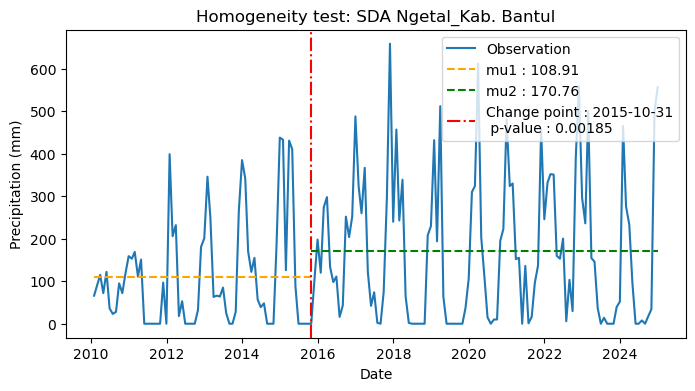

In [86]:
test_data = data_yearly["34021001a"]

pettitt_res = hg.pettitt_test(test_data)

mn = test_data.index[0]
mx = test_data.index[-1]

loc = pd.to_datetime(pettitt_res.cp)
mu1 = pettitt_res.avg.mu1
mu2 = pettitt_res.avg.mu2

plt.figure(figsize=(8,4))
plt.plot(test_data, label="Observation")
plt.hlines(mu1, xmin=mn, xmax=loc, linestyles='--', colors='orange',lw=1.5, label='mu1 : ' + str(round(mu1,2)))
plt.hlines(mu2, xmin=loc, xmax=mx, linestyles='--', colors='g', lw=1.5, label='mu2 : ' + str(round(mu2,2)))
plt.axvline(x=loc, linestyle='-.' , color='red', lw=1.5, label='Change point : '+ loc.strftime('%Y-%m-%d') + '\n p-value : ' + str(result.p))

plt.title('Homogeneity test: SDA Ngetal_Kab. Bantul')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(loc='upper right')

In [138]:
# read homogeneity test results
homogenitas = pd.read_excel('data/hasil_uji_homogenitas.xlsx')
homogenitas

Pos Hujan ID Nama Pos Hujan         Kabupaten  Pettitt_Homogeneous  \
0     34010101a      BPP Temon  Kab. Kulon Progo                 True   
1     34010201a           Beji  Kab. Kulon Progo                 True   
2     34010202a    BPP Kulwaru  Kab. Kulon Progo                 True   
3     34010301a   BPP Panjatan  Kab. Kulon Progo                 True   
4     34010401a    PSDA Brosot  Kab. Kulon Progo                 True   
..          ...            ...               ...                  ...   
77    34041601a          Pakem       Kab. Sleman                 True   
78    34041701a      Bronggang       Kab. Sleman                 True   
79    34041702a          Cepit       Kab. Sleman                 True   
80    34041704a        Gondang       Kab. Sleman                 True   
81    34021301a     BPP Pleret       Kab. Bantul                 True   

    Pettitt_p_value  Pettitt_CP  Buishand_Homogeneous  Buishand_p_value  \
0           0.29670  2014-12-31                  True           0.53395   
1           0.97765  2020-12-31                  True           0.96105   
2           0.29855  2015-12-31                  True           0.55055   
3           0.45810  2013-12-31                  True           0.36950   
4           0.66755  2017-12-31                  True           0.91975   
..              ...         ...                   ...               ...   
77          0.77120  2015-12-31                  True           0.76220   
78          0.55690  2015-12-31                  True           0.48610   
79          0.22320  2015-12-31                  True           0.52465   
80          0.46610  2019-12-31                  True           0.67725   
81          0.12660  2012-12-31                  True           0.27195   

   Buishand_CP  SNHT_Homogeneous  SNHT_p_value     SNHT_CP  \
0   2019-12-31              True       0.57780  2019-12-31   
1   2021-12-31              True       0.94885  2021-12-31   
2   2015-12-31              True       0.68285  2015-12-31   
3   2015-12-31              True       0.48775  2015-12-31   
4   2017-12-31              True       0.94565  2022-12-31   
..         ...               ...           ...         ...   
77  2015-12-31              True       0.92080  2015-12-31   
78  2019-12-31              True       0.80585  2019-12-31   
79  2015-12-31             False       0.01340  2010-12-31   
80  2012-12-31             False       0.00530  2010-12-31   
81  2012-12-31             False       0.02285  2012-12-31   

    vonNeumann_Homogeneous  vonNeumann_p_value  vonNeumann_V  
0                     True            0.924574      1.951111  
1                     True            0.233134      2.615713  
2                     True            0.480037      2.364702  
3                     True            0.916075      2.054418  
4                     True            0.435431      2.402755  
..                     ...                 ...           ...  
77                    True            0.590538      2.277851  
78                    True            0.935450      2.041823  
79                    True            0.533750      1.678650  
80                    True            0.543144      1.685996  
81                    True            0.848872      1.901596  

[82 rows x 15 columns]

In [139]:
# Define the homogeneity acceptance rule
# A station is considered homogeneous if at least 3 out of 4 tests return "Homogeneous = TRUE"
homogenitas['Jumlah_Tes_Homogen'] = (
      homogenitas[['Pettitt_Homogeneous',
                   'Buishand_Homogeneous',
                   'SNHT_Homogeneous',
                   'vonNeumann_Homogeneous']].sum(axis=1)
)

# Create a column indicating whether a station passes the homogeneity criteria
homogenitas['Lolos_Homogenitas'] = homogenitas['Jumlah_Tes_Homogen'] >= 2

# Extract the stations that do NOT meet the homogeneity criteria
stasiun_tidak_lolos = homogenitas[homogenitas['Lolos_Homogenitas'] == False]

print("\n=== Stations that did NOT pass the homogeneity test ===")
for _, row in stasiun_tidak_lolos.iterrows():
    print(f"- {row['Pos Hujan ID']} | {row['Nama Pos Hujan']} | {row['Kabupaten']}")

# Filter the daily rainfall dataset to keep only homogeneous stations
stasiun_lolos = homogenitas[homogenitas['Lolos_Homogenitas'] == True]['Pos Hujan ID']

data_homogen_only = data_filtered_new[stasiun_lolos]

print("\nNumber of homogeneous stations:", len(stasiun_lolos))
print("Number of non-homogeneous stations:", len(stasiun_tidak_lolos))



=== Stations that did NOT pass the homogeneity test ===
- 34020801a | SDA Ringinharjo | Kab. Bantul
- 34020901a | SDA Barongan | Kab. Bantul
- 34021002a | BPP Imogiri | Kab. Bantul

Number of homogeneous stations: 79
Number of non-homogeneous stations: 3


In [140]:
# Filter metadata to keep only the stations that passed the homogeneity test
metadata_homogen_only = metadata_filtered[
    metadata_filtered.index.isin(stasiun_lolos)
]

# Save the filtered metadata
metadata_homogen_only.to_excel(
    f"data/metadata_{threshold}%_{len(metadata_homogen_only.index)}pos_{year_start}.xlsx"
)

# Save the rainfall data for homogeneous stations
data_homogen_only.to_excel(
    f"data/dailyprecip_{threshold}%_{len(data_homogen_only.columns)}pos_{year_start}.xlsx"
)

# Print confirmation message
print(
    f"data/dailyprecip_{threshold}%_{len(data_homogen_only.columns)}pos_{year_start}.xlsx saved"
)


data/dailyprecip_10%_79pos_2010-01-01.xlsx saved


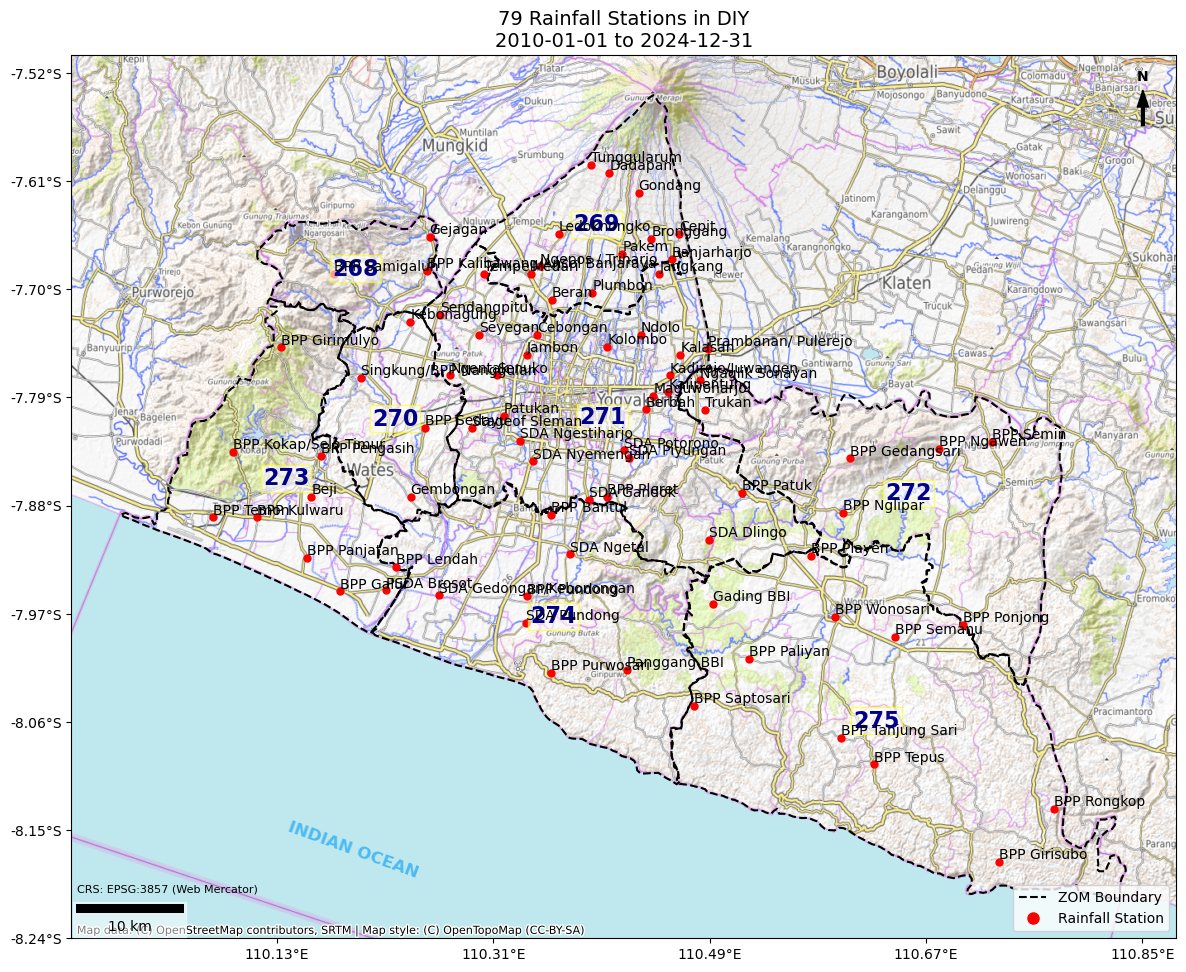

In [7]:
# Plot homogeneous station locations based on the filtered metadata
plot_stasiun_gdf(metadata_homogen_only)

In [147]:
# Read metadata homogeneous only
metadata_homogen_only = pd.read_excel(f"data/metadata_{threshold}%_{len(metadata_homogen_only.index)}pos_{year_start}.xlsx")
metadata_homogen_only = metadata_homogen_only.set_index(['Pos Hujan ID'])
metadata_homogen_only

# Read data homogeneous only
data_homogen_only = pd.read_excel(f"data/dailyprecip_{threshold}%_{len(data_homogen_only.columns)}pos_{year_start}.xlsx") 
data_homogen_only = data_homogen_only.set_index(['DATA TIMESTAMP'])
data_homogen_only

34010101a  34010201a  34010202a  34010301a  34010401a  \
DATA TIMESTAMP                                                          
2010-01-01            0.0        0.0        0.0        0.0        0.0   
2010-01-02            0.0        0.0        0.0        0.0        0.0   
2010-01-03            0.0        0.0        0.0        0.0        0.0   
2010-01-04           11.0       13.0        0.0        0.0        0.0   
2010-01-05            8.0        0.0       12.0       11.0       30.0   
...                   ...        ...        ...        ...        ...   
2024-12-27           35.0       17.6       29.0       31.5       23.0   
2024-12-28            0.0        0.0        0.0        0.0        1.0   
2024-12-29           11.0        9.0        6.5        6.0        3.0   
2024-12-30           17.0       14.7       20.5       19.5       10.0   
2024-12-31            3.0        5.6        7.5        6.0        0.0   

                34010402a  34010501a  34010601a  34010701a  34010801a  ...  \
DATA TIMESTAMP                                                         ...   
2010-01-01            0.0        0.0        0.0        0.0        0.0  ...   
2010-01-02            0.0        0.0        0.0        0.0        0.0  ...   
2010-01-03            0.0        0.0        0.0        0.0        0.0  ...   
2010-01-04            0.0        0.0        0.0        0.0        7.0  ...   
2010-01-05           30.0       30.0        0.0        0.0        2.0  ...   
...                   ...        ...        ...        ...        ...  ...   
2024-12-27           21.5       23.0       13.0       11.1       18.0  ...   
2024-12-28            0.0        5.0        0.0        0.0        0.0  ...   
2024-12-29            6.0        4.0       13.0        3.2        4.0  ...   
2024-12-30           14.0       15.0       12.0       24.8        1.5  ...   
2024-12-31            2.5        7.0        3.0        0.9        0.0  ...   

                34041303a  34041401a  34041501a  34041502a  34041504a  \
DATA TIMESTAMP                                                          
2010-01-01            0.0        0.0       58.0       57.0        NaN   
2010-01-02            0.0        0.0       55.0       53.0        NaN   
2010-01-03            0.0        0.0       20.0       17.0        NaN   
2010-01-04            7.0       13.0        0.0        0.0        NaN   
2010-01-05            0.0        0.0        0.0        0.0        NaN   
...                   ...        ...        ...        ...        ...   
2024-12-27           24.0       21.5        9.0       11.5        9.0   
2024-12-28            0.0        0.0        0.0        0.0        2.4   
2024-12-29            5.0       10.0       11.0       11.0       13.0   
2024-12-30            3.0        3.5        4.5        2.5        3.2   
2024-12-31            3.0       12.0       20.0       26.0       21.0   

                34041601a  34041701a  34041702a  34041704a  34021301a  
DATA TIMESTAMP                                                         
2010-01-01           25.0       22.0        NaN        NaN        0.0  
2010-01-02            2.0        2.0        NaN        NaN        0.0  
2010-01-03            0.0        1.0        NaN        NaN        0.0  
2010-01-04            0.0        0.0        NaN        NaN        0.0  
2010-01-05            0.0        0.0        NaN        NaN        0.0  
...                   ...        ...        ...        ...        ...  
2024-12-27           10.5       10.0        4.5        5.5       16.0  
2024-12-28            0.0        0.0        0.0        0.0        0.0  
2024-12-29           10.5       11.0        8.0       18.0        4.0  
2024-12-30            5.0        6.0        0.5        2.0       11.5  
2024-12-31           45.5       33.5       18.5       21.0        1.0  

[5479 rows x 79 columns]

In [148]:
import math
import random
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Reload variable
year_start = '2010-01-01'
year_end = '2024-12-31'
threshold = 10

In [145]:
def impute_missing_by_same_day_mean(data_df, mask_fraction=0.1, random_state=42):
    """
    Imputes missing values using the mean of observations on the same month and day
    across other years. The procedure includes:
      1. Generating a masked subset of non-missing values for cross-validation.
      2. Imputing only masked values for evaluation purposes.
      3. Computing evaluation metrics using the masked subset.
      4. Imputing only the original missing values (not the masked ones).
    """

    np.random.seed(random_state)
    stations = data_df.columns.tolist()

    # Copy original data
    df_original = data_df.copy()

    # Ensure the index is a datetime index
    if not isinstance(df_original.index, pd.DatetimeIndex):
        raise ValueError("The index of data_df must be a DatetimeIndex.")

    # Build masking matrix for cross-validation
    mask_matrix = np.zeros(data_df.shape, dtype=bool)
    for col_idx, col in enumerate(data_df.columns):
        valid_idx = np.where(~data_df[col].isna())[0]
        n_mask = int(len(valid_idx) * mask_fraction)
        if n_mask > 0:
            mask_idx = np.random.choice(valid_idx, size=n_mask, replace=False)
            mask_matrix[mask_idx, col_idx] = True

    # Apply masking
    df_masked = df_original.mask(mask_matrix)
    df_eval_imputed = df_masked.copy()

    # Impute masked values for evaluation
    for col in df_eval_imputed.columns:
        for date_idx, val in enumerate(df_eval_imputed[col]):
            if mask_matrix[date_idx, df_eval_imputed.columns.get_loc(col)]:
                this_date = df_eval_imputed.index[date_idx]

                same_day_vals = df_original.loc[
                    (df_original.index.month == this_date.month) &
                    (df_original.index.day == this_date.day),
                    col
                ].dropna()

                if len(same_day_vals) > 0:
                    df_eval_imputed.iat[date_idx, df_eval_imputed.columns.get_loc(col)] = same_day_vals.mean()

    # Compute evaluation metrics
    metrics = []
    for col in df_eval_imputed.columns:
        true_vals = df_original[col].values
        pred_vals = df_eval_imputed[col].values
        mask_eval = mask_matrix[:, df_eval_imputed.columns.get_loc(col)]

        if np.sum(mask_eval) > 1:
            rmse = np.sqrt(mean_squared_error(true_vals[mask_eval], pred_vals[mask_eval]))
            mae = mean_absolute_error(true_vals[mask_eval], pred_vals[mask_eval])
            bias = np.mean(pred_vals[mask_eval] - true_vals[mask_eval])
            r2 = r2_score(true_vals[mask_eval], pred_vals[mask_eval])

            numerator = np.sum((true_vals[mask_eval] - pred_vals[mask_eval]) ** 2)
            denominator = np.sum((true_vals[mask_eval] - np.mean(true_vals[mask_eval])) ** 2)
            nse = 1 - (numerator / denominator) if denominator != 0 else np.nan
        else:
            rmse = mae = bias = r2 = nse = np.nan

        metrics.append({
            "Stasiun": col,
            "RMSE": rmse,
            "MAE": mae,
            "Bias": bias,
            "R2": r2,
            "NSE": nse
        })

    metrics_df = pd.DataFrame(metrics)

    # Impute only original missing values
    df_final = df_original.copy()
    for col in df_final.columns:
        for date_idx, val in enumerate(df_final[col]):
            if np.isnan(val):
                this_date = df_final.index[date_idx]

                same_day_vals = df_final.loc[
                    (df_final.index.month == this_date.month) &
                    (df_final.index.day == this_date.day),
                    col
                ].dropna()

                if len(same_day_vals) > 0:
                    df_final.iat[date_idx, df_final.columns.get_loc(col)] = same_day_vals.mean()

    df_final = df_final.round(1)

    return df_final, metrics_df


def plot_metrics(metrics_df, metadata_filtered):
    """
    Creates bar plots of the evaluation metrics (RMSE, MAE, Bias, R²)
    using station names instead of station IDs.
    """

    # Map station ID to station name
    id_to_name = metadata_filtered["Nama Stasiun"].to_dict()

    # Use station names in the metrics dataframe
    metrics_df = metrics_df.copy()
    metrics_df["Nama Stasiun"] = metrics_df["Stasiun"].map(id_to_name)

    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    metrics = ["RMSE", "MAE", "Bias", "R2"]
    titles = ["RMSE", "MAE", "Bias", "R²"]

    for ax, metric, title in zip(axes.flatten(), metrics, titles):
        sns.barplot(
            data=metrics_df,
            x="Nama Stasiun",
            y=metric,
            ax=ax,
            palette="viridis"
        )
        ax.set_title(title)
        ax.set_xlabel("Nama Stasiun")
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=90, labelsize=6)
        ax.tick_params(axis='y', labelsize=9)

    plt.tight_layout()
    # plt.show()


In [ ]:
data_imputed_mean, metrics_mean = impute_missing_by_same_day_mean(data_homogen_only, mask_fraction=0.1)
data_imputed_mean.to_excel(f"data/dailyprecip_{threshold}%_{len(data_imputed_mean.columns)}pos_{year_start}_imputed.xlsx")
print(f"Saved data/dailyprecip_{threshold}%_{len(data_imputed_mean.columns)}pos_{year_start}_imputed.xlsx")
# plot_metrics(metrics_mean, metadata_homogen_only)

Saved data/dailyprecip_10%_79pos_2010-01-01_imputed_mean.xlsx


In [ ]:
# from pyproj import Transformer
# from scipy.spatial import cKDTree

# def compute_distance_matrix_latlon(latlon_df):
#     """
#     Compute a distance matrix (meters) from latitude/longitude coordinates.
#     Coordinates are projected to UTM Zone 49S (EPSG:32749) for accuracy
#     in the Special Region of Yogyakarta.
#     """
#     coords = latlon_df[['Lintang', 'Bujur']].to_numpy(dtype=float)

#     # Project to UTM zone 49S (EPSG:32749)
#     transformer = Transformer.from_crs("EPSG:4326", "EPSG:32749", always_xy=True)
#     xs, ys = transformer.transform(coords[:, 1], coords[:, 0])  # lon, lat
#     coords_utm = np.column_stack([xs, ys])

#     # Compute Euclidean distance matrix
#     dist_m = distance_matrix(coords_utm, coords_utm)
#     dist_m[dist_m == 0] = 1e-6  # avoid division by zero
#     return dist_m


# def idw_imputation(data_df, metadata_df, power=2, max_neighbors=5,
#                    mask_fraction=0.1, random_state=42):
#     """
#     Perform IDW-based imputation with cross-validation masking.
#       1. Generate partial masking for cross-validation.
#       2. Impute only the masked values for evaluation.
#       3. Compute evaluation metrics using masked values.
#       4. Impute only the original missing values.
#     """
#     np.random.seed(random_state)

#     # Align metadata with data columns
#     metadata_df = metadata_df.loc[data_df.columns]
#     stations = metadata_df.index.tolist()

#     # Pre-compute distance matrix
#     dist_mat = compute_distance_matrix_latlon(metadata_df)

#     # Copy original data
#     df_original = data_df.copy()

#     # Build masking matrix
#     mask_matrix = np.zeros(data_df.shape, dtype=bool)
#     for col_idx, col in enumerate(data_df.columns):
#         valid_idx = np.where(~data_df[col].isna())[0]
#         n_mask = int(len(valid_idx) * mask_fraction)
#         if n_mask > 0:
#             chosen_idx = np.random.choice(valid_idx, size=n_mask, replace=False)
#             mask_matrix[chosen_idx, col_idx] = True

#     # Apply masking
#     df_masked = df_original.mask(mask_matrix)
#     df_eval_imputed = df_masked.copy()

#     # IDW imputation for masked values
#     for date_idx in range(df_eval_imputed.shape[0]):
#         values_today = df_eval_imputed.iloc[date_idx, :].values
#         for station_idx in range(len(stations)):
#             if mask_matrix[date_idx, station_idx]:
#                 valid_mask = ~np.isnan(values_today)
#                 if not np.any(valid_mask):
#                     continue

#                 distances = dist_mat[station_idx, valid_mask]
#                 values = values_today[valid_mask]

#                 neighbor_order = np.argsort(distances)[:max_neighbors]
#                 distances = distances[neighbor_order]
#                 values = values[neighbor_order]

#                 weights = 1 / (distances ** power)
#                 df_eval_imputed.iat[date_idx, station_idx] = np.sum(weights * values) / np.sum(weights)

#     # Evaluate imputation accuracy
#     metrics = []
#     for col in range(len(stations)):
#         true_vals = df_original.iloc[:, col].values
#         pred_vals = df_eval_imputed.iloc[:, col].values
#         mask_eval = mask_matrix[:, col]

#         if np.sum(mask_eval) > 1:
#             rmse = np.sqrt(mean_squared_error(true_vals[mask_eval], pred_vals[mask_eval]))
#             mae = mean_absolute_error(true_vals[mask_eval], pred_vals[mask_eval])
#             bias = np.mean(pred_vals[mask_eval] - true_vals[mask_eval])
#             r2 = r2_score(true_vals[mask_eval], pred_vals[mask_eval])

#             numerator = np.sum((pred_vals[mask_eval] - true_vals[mask_eval]) ** 2)
#             denominator = np.sum((true_vals[mask_eval] - np.mean(true_vals[mask_eval])) ** 2)
#             nse = 1 - numerator / denominator if denominator != 0 else np.nan
#         else:
#             rmse = mae = bias = r2 = nse = np.nan

#         metrics.append({
#             "Stasiun": stations[col],
#             "RMSE": rmse,
#             "MAE": mae,
#             "Bias": bias,
#             "R2": r2,
#             "NSE": nse
#         })

#     metrics_df = pd.DataFrame(metrics)

#     # IDW imputation for original missing values
#     df_final = df_original.copy()
#     for date_idx in range(df_final.shape[0]):
#         values_today = df_final.iloc[date_idx, :].values
#         for station_idx in range(len(stations)):
#             if np.isnan(df_original.iat[date_idx, station_idx]):
#                 valid_mask = ~np.isnan(values_today)
#                 if not np.any(valid_mask):
#                     continue

#                 distances = dist_mat[station_idx, valid_mask]
#                 values = values_today[valid_mask]

#                 neighbor_order = np.argsort(distances)[:max_neighbors]
#                 distances = distances[neighbor_order]
#                 values = values[neighbor_order]

#                 weights = 1 / (distances ** power)
#                 df_final.iat[date_idx, station_idx] = np.sum(weights * values) / np.sum(weights)

#     df_final = df_final.round(1)
#     return df_final, metrics_df


# def knn_imputation(data_df, metadata_df, k=5,
#                    mask_fraction=0.1, random_state=42):
#     """
#     Perform KNN-based imputation with cross-validation masking.
#       1. Generate partial masking for cross-validation.
#       2. Impute only the masked values for evaluation.
#       3. Compute evaluation metrics using masked values.
#       4. Impute only the original missing values.
#     """
#     np.random.seed(random_state)

#     # Align metadata with data columns
#     metadata_df = metadata_df.loc[data_df.columns]
#     stations = metadata_df.index.tolist()

#     # Distance matrix
#     dist_mat = compute_distance_matrix_latlon(metadata_df)

#     # Copy original
#     df_original = data_df.copy()

#     # Build masking matrix
#     mask_matrix = np.zeros(data_df.shape, dtype=bool)
#     for col_idx, col in enumerate(data_df.columns):
#         valid_idx = np.where(~data_df[col].isna())[0]
#         n_mask = int(len(valid_idx) * mask_fraction)
#         if n_mask > 0:
#             chosen_idx = np.random.choice(valid_idx, size=n_mask, replace=False)
#             mask_matrix[chosen_idx, col_idx] = True

#     # Apply masking
#     df_masked = df_original.mask(mask_matrix)
#     df_eval_imputed = df_masked.copy()

#     # KNN imputation for masked values
#     for date_idx in range(df_eval_imputed.shape[0]):
#         values_today = df_eval_imputed.iloc[date_idx, :].values
#         for station_idx in range(len(stations)):
#             if mask_matrix[date_idx, station_idx]:
#                 valid_mask = ~np.isnan(values_today)
#                 if not np.any(valid_mask):
#                     continue

#                 distances = dist_mat[station_idx, valid_mask]
#                 values = values_today[valid_mask]

#                 neighbor_order = np.argsort(distances)[:k]
#                 values = values[neighbor_order]

#                 df_eval_imputed.iat[date_idx, station_idx] = np.mean(values)

#     # Evaluate imputation accuracy
#     metrics = []
#     for col in range(len(stations)):
#         true_vals = df_original.iloc[:, col].values
#         pred_vals = df_eval_imputed.iloc[:, col].values
#         mask_eval = mask_matrix[:, col]

#         if np.sum(mask_eval) > 1:
#             rmse = np.sqrt(mean_squared_error(true_vals[mask_eval], pred_vals[mask_eval]))
#             mae = mean_absolute_error(true_vals[mask_eval], pred_vals[mask_eval])
#             bias = np.mean(pred_vals[mask_eval] - true_vals[mask_eval])
#             r2 = r2_score(true_vals[mask_eval], pred_vals[mask_eval])

#             numerator = np.sum((pred_vals[mask_eval] - true_vals[mask_eval]) ** 2)
#             denominator = np.sum((true_vals[mask_eval] - np.mean(true_vals[mask_eval])) ** 2)
#             nse = 1 - numerator / denominator if denominator != 0 else np.nan
#         else:
#             rmse = mae = bias = r2 = nse = np.nan

#         metrics.append({
#             "Stasiun": stations[col],
#             "RMSE": rmse,
#             "MAE": mae,
#             "Bias": bias,
#             "R2": r2,
#             "NSE": nse
#         })

#     metrics_df = pd.DataFrame(metrics)

#     # KNN imputation for original missing values
#     df_final = df_original.copy()
#     for date_idx in range(df_final.shape[0]):
#         values_today = df_final.iloc[date_idx, :].values
#         for station_idx in range(len(stations)):
#             if np.isnan(df_original.iat[date_idx, station_idx]):
#                 valid_mask = ~np.isnan(values_today)
#                 if not np.any(valid_mask):
#                     continue

#                 distances = dist_mat[station_idx, valid_mask]
#                 values = values_today[valid_mask]

#                 neighbor_order = np.argsort(distances)[:k]
#                 values = values[neighbor_order]

#                 df_final.iat[date_idx, station_idx] = np.mean(values)

#     df_final = df_final.round(1)
#     return df_final, metrics_df


In [ ]:
# data_imputed_idw, metrics_idw = idw_imputation(data_df=data_homogen_only, metadata_df=metadata_homogen_only, power=2, max_neighbors=12, mask_fraction=0.1)
# plot_metrics(metrics_idw, metadata_homogen_only)
# data_imputed_idw.to_excel(f"data/dailyprecip_{threshold}%_{len(data_imputed_idw.columns)}pos_{year_start}_imputed_idw.xlsx")
# print(f"Saved data/dailyprecip_{threshold}%_{len(data_imputed_idw.columns)}pos_{year_start}_imputed_idw.xlsx")